In [2]:
import os
import pandas as pd
import librosa

# Пути к данным
data_path = './jvs_ver1/'
audio_files = []

def load_data_to_dataframe(data_path):
    data = []
    for speaker in os.listdir(data_path):
        speaker_dir = os.path.join(data_path, speaker)
        if not os.path.isdir(speaker_dir):
            continue
        
        for subfolder in ['nonpara30', 'parallel100']:
            wav_path = os.path.join(speaker_dir, subfolder, 'wav24kHz16bit')
            transcripts_path = os.path.join(speaker_dir, subfolder, 'transcripts_utf8.txt')
            
            if not os.path.isdir(wav_path) or not os.path.exists(transcripts_path):
                continue
            
            with open(transcripts_path, 'r', encoding='utf-8') as f:
                transcripts = f.readlines()
            
            for line in transcripts:
                file_name, text = line.strip().split(':')
                audio_path = os.path.join(wav_path, f'{file_name}.wav')
            
                if os.path.exists(audio_path):
                    audio_files.append(audio_path)
                    #audio, sr = librosa.load(audio_path, sr=24000)
                    data.append({'text': text, 'audio': audio_path})
    
    df = pd.DataFrame(data)
    return df

data_df = load_data_to_dataframe(data_path)

In [4]:
import librosa

# Load and preprocess audio files
def preprocess_audio(file_paths):
    X = []
    for path in file_paths:
        y, sr = librosa.load(path, sr=None)  # Load audio file
        mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to dB
        # Normalize
        mel_spectrogram_db = (mel_spectrogram_db - np.min(mel_spectrogram_db)) / (np.max(mel_spectrogram_db) - np.min(mel_spectrogram_db))
        X.append(mel_spectrogram_db.T)  # Transpose to have shape (time_steps, n_mels)
    return X

def pad_sequences(sequences, max_length):
    return tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')


In [4]:
# Preprocess and pad sequences
data = preprocess_audio(audio_files)
data_padded = pad_sequences(data, max_length)

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, TimeDistributed
from sklearn.preprocessing import StandardScaler

tf.config.run_functions_eagerly(True)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)


n_mels = 128  # Number of Mel bands
max_length = 100 
batch_size = 256
epochs = 10

model = Sequential([
    Masking(mask_value=0.0, input_shape=(max_length, n_mels)),
    LSTM(64, return_sequences=True, activation='tanh'),
    LSTM(64, return_sequences=True, activation='tanh'),
    TimeDistributed(Dense(n_mels, activation='linear'))
])

model.compile(optimizer='adam', loss='mean_squared_error')

/home/sokket/ML/speak-it-easy/venv/lib/python3.10/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-07-23 15:25:33.889770: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22175 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
# Train the model
model.fit(data_padded, data_padded, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [12]:
model.save('unsupervised_lstm_model2.keras')

In [8]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking, TimeDistributed
from sklearn.preprocessing import StandardScaler

folder_path = 'test'
file_list = os.listdir(folder_path)
mp3_files = [os.path.join(folder_path, f) for f in file_list if f.endswith('.mp3')]
n_mels = 128
max_length = 100 
test_data = preprocess_audio(mp3_files)
test_data_padded = pad_sequences(test_data, max_length)

2024-07-23 15:23:59.977272: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 15:23:59.984792: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 15:23:59.987158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 15:23:59.995939: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 15:24:00.810699: W tensorflow/compiler/tf2

In [12]:
new_model = tf.keras.models.load_model('unsupervised_lstm_model2.keras')

/home/sokket/ML/speak-it-easy/venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
new_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_6 (Masking)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 100, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100, 64)        │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 100, 128)       │         8,320 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 181,506 (709.01 KB)

 Trainable params: 90,752 (354.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 90,754 (354.51 KB)

In [15]:
np.mean((test_data_padded - new_model.predict(test_data_padded)) ** 2)

/home/sokket/ML/speak-it-easy/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 576ms/step


0.00024010464738090858

In [16]:
ugly_files = ['record.wav']

In [17]:
ugly_data = preprocess_audio(ugly_files)
ugly_data_padded = pad_sequences(ugly_data, max_length)

In [18]:
np.mean((ugly_data_padded - new_model.predict(ugly_data_padded)) ** 2)

/home/sokket/ML/speak-it-easy/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step


0.00024010464738090771

In [19]:
import librosa
import numpy as np

def load_audio(file_path, sr=22050):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

In [21]:
audio_ok = load_audio('test/My Recording - 1-A.mp3')
audio_bad = load_audio('record.wav')

In [22]:
def split_audio(audio, chunk_length, sr=22050):
    num_chunks = int(np.ceil(len(audio) / (chunk_length * sr)))
    chunks = []
    for i in range(num_chunks):
        start = i * chunk_length * sr
        end = start + chunk_length * sr
        chunk = audio[start:end]
        if len(chunk) < chunk_length * sr:
            # Дополнение нулями до нужной длины
            chunk = np.pad(chunk, (0, chunk_length * sr - len(chunk)), 'constant')
        chunks.append(chunk)
    return np.array(chunks)

chunk_length = 5  # Длина каждого куска в секундах
chunks_ok = split_audio(audio_ok, chunk_length)
chunks_bad = split_audio(audio_bad, chunk_length)

In [23]:
chunks_ok

array([[ 8.7311491e-11,  6.5483619e-11, -3.6379788e-11, ...,
         8.5093547e-04,  6.1532640e-04,  5.0871284e-04],
       [ 4.9108395e-04,  4.9488078e-04,  4.5758835e-04, ...,
        -1.2134991e-03, -1.2401864e-03, -1.1457187e-03],
       [-1.0560628e-03, -1.1146666e-03, -1.1307452e-03, ...,
         3.9046293e-04,  4.5041530e-04,  4.7916942e-04],
       ...,
       [ 1.4130271e-04,  3.5342481e-04,  5.5517373e-04, ...,
        -4.3693936e-04, -2.8565593e-04, -1.5706425e-04],
       [-2.6348938e-04, -6.8001289e-05, -9.0141009e-05, ...,
        -3.5257969e-04, -3.5614762e-04, -1.5496626e-04],
       [ 1.5331362e-04,  4.3814967e-04,  6.5104361e-04, ...,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32)

In [24]:
chunks_bad

array([[0.        , 0.        , 0.        , ..., 0.00505375, 0.00456167,
        0.00368486],
       [0.00249094, 0.00119785, 0.00023357, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [25]:
def audio_to_spectrogram(audio_chunks, sr=22050, n_fft=2048, hop_length=512):
    spectrograms = []
    for chunk in audio_chunks:
        stft = librosa.stft(chunk, n_fft=n_fft, hop_length=hop_length)
        spectrogram = np.abs(stft)
        spectrograms.append(spectrogram)
    return np.array(spectrograms)

In [26]:
spectrograms_ok = audio_to_spectrogram(chunks_ok)
spectrograms_bad = audio_to_spectrogram(chunks_bad)

In [27]:
spectrograms_ok

array([[[3.14391255e-02, 1.04301780e-01, 8.43964741e-02, ...,
         9.48121846e-02, 5.71775809e-02, 1.04824074e-01],
        [3.31799462e-02, 1.15729913e-01, 6.83377758e-02, ...,
         8.79187211e-02, 1.81006268e-02, 1.08011819e-01],
        [3.66915651e-02, 1.66364953e-01, 1.38910085e-01, ...,
         8.18928257e-02, 3.82486582e-02, 1.46217152e-01],
        ...,
        [5.48335599e-09, 9.94084548e-09, 5.46146417e-09, ...,
         2.84681043e-08, 6.99478114e-05, 2.59792811e-04],
        [4.22102531e-09, 6.26670538e-09, 9.27092003e-09, ...,
         7.29885175e-09, 6.99134835e-05, 2.59762513e-04],
        [8.11131873e-09, 5.21485832e-09, 1.16784404e-08, ...,
         8.18267587e-09, 6.99126904e-05, 2.59780558e-04]],

       [[4.69651036e-02, 5.41963195e-03, 1.00114927e-01, ...,
         3.57093625e-02, 6.59609726e-03, 7.33056143e-02],
        [5.64321391e-02, 8.94839838e-02, 7.93052465e-02, ...,
         5.03794253e-02, 3.96976247e-02, 9.74806026e-02],
        [6.54584393e-02, 

In [28]:
spectrograms_bad

array([[[5.6065812e-12, 1.7717031e-10, 3.1008141e-03, ...,
         4.4319391e-02, 2.3035008e-02, 1.0577471e-03],
        [5.6798823e-12, 1.8970753e-10, 3.1510033e-03, ...,
         4.7794748e-03, 2.0898342e-02, 1.3465786e-02],
        [5.8981973e-12, 2.0611941e-10, 3.3158199e-03, ...,
         2.8965272e-02, 7.8301802e-03, 1.1281529e-02],
        ...,
        [2.4669490e-12, 6.3694945e-11, 3.4948847e-08, ...,
         5.5782952e-08, 3.8227171e-04, 1.4187138e-03],
        [2.5561671e-12, 5.7826872e-11, 3.4073121e-08, ...,
         1.9728230e-08, 3.8229767e-04, 1.4188515e-03],
        [2.5861583e-12, 5.3752478e-11, 3.4016193e-08, ...,
         1.9424904e-08, 3.8227325e-04, 1.4186945e-03]],

       [[7.7978395e-02, 1.3533539e-01, 8.4980056e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [6.3189439e-02, 1.1109784e-01, 5.6764714e-02, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
        [2.9977644e-02, 7.3047198e-02, 4.2251866e-02, ...,
         0.000

In [29]:
def pad_spectrograms(spectrograms):
    max_length = max(spectrogram.shape[1] for spectrogram in spectrograms)
    padded_spectrograms = []
    for spectrogram in spectrograms:
        if spectrogram.shape[1] < max_length:
            padding = max_length - spectrogram.shape[1]
            spectrogram = np.pad(spectrogram, ((0, 0), (0, padding)), 'constant')
        elif spectrogram.shape[1] > max_length:
            spectrogram = spectrogram[:, :max_length]
        padded_spectrograms.append(spectrogram)
    return np.array(padded_spectrograms)

In [30]:
padded_spectrograms_ok = pad_spectrograms(spectrograms_ok)
padded_spectrograms_bad = pad_spectrograms(spectrograms_bad)

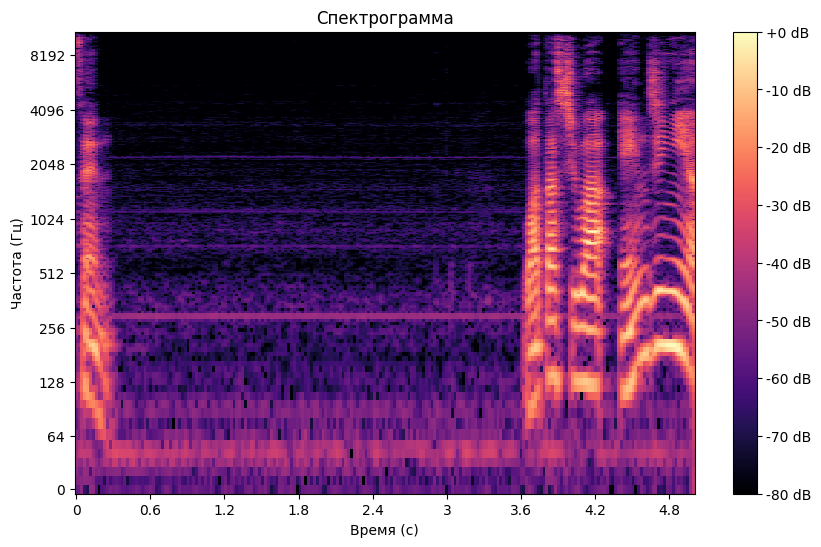

In [44]:
import matplotlib.pyplot as plt
import librosa.display

sr = 22050  # Частота дискретизации
n_fft = 2048  # Размер окна Фурье
hop_length = 512  # Шаг между окнами

# Отображение спектрограммы
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(padded_spectrograms_ok[4], ref=np.max), sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Спектрограмма')
plt.xlabel('Время (с)')
plt.ylabel('Частота (Гц)')
plt.show()

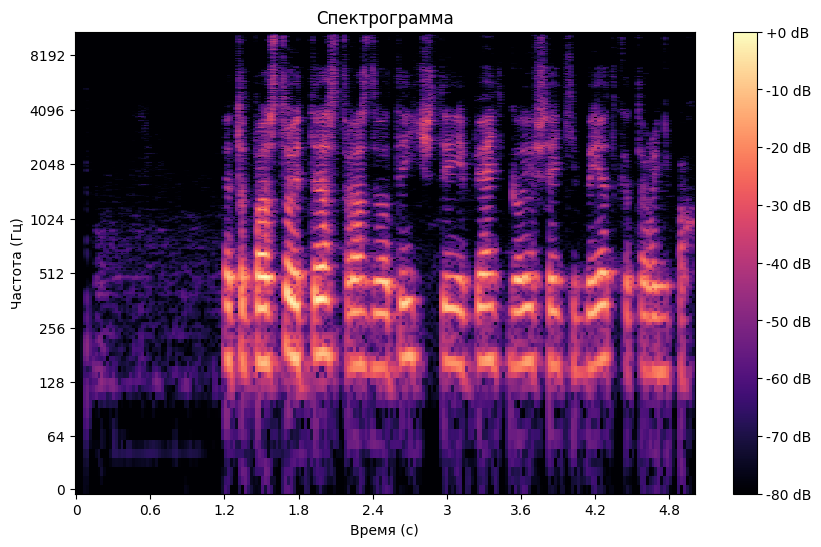

In [41]:
# Отображение спектрограммы
plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(padded_spectrograms_bad[0], ref=np.max), sr=sr, hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Спектрограмма')
plt.xlabel('Время (с)')
plt.ylabel('Частота (Гц)')
plt.show()